# CIFAR vectorized LiRA example

This notebook mirrors A_cifar_main.ipynb but configures the LiRA attack to use the vectorized fast path.

It is safer to delete previous results for target and shadow models as it will train new models. 


In [1]:
import os
import sys
import yaml

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)

train_config_path = "train_robust.yaml"
audit_config_path = "audit_robust.yaml"


Next, we create the population dataset by concatenating the train and test data. To create the population, we make use of the UserDataset provided in the InputHandler.

In [2]:
from torchvision.datasets import CIFAR10, CIFAR100
from torch import cat, tensor
import pickle
from cifar_handler import CifarInputHandler

# Load the config.yaml file
with open(train_config_path, 'r') as file:
    train_config = yaml.safe_load(file)

data_root = train_config["data"]["data_dir"]
data_path = os.path.join(os.getcwd(), data_root)

# Load the CIFAR train and test datasets
if train_config["data"]["dataset"] == "cifar10":
    trainset = CIFAR10(root=data_root, train=True, download=True)
    testset = CIFAR10(root=data_root, train=False, download=True)
elif train_config["data"]["dataset"] == "cifar100":
    trainset = CIFAR100(root=data_root, train=True, download=True)
    testset = CIFAR100(root=data_root, train=False, download=True)
else:
    raise ValueError("Unknown dataset type")

train_data = tensor(trainset.data).permute(0, 3, 1, 2).float() / 255  # (N, C, H, W)
test_data = tensor(testset.data).permute(0, 3, 1, 2).float() / 255

# Ensure train and test data looks correct
assert train_data.shape[0] == 50000, "Train data should have 50000 samples"
assert test_data.shape[0] == 10000, "Test data should have 10000 samples"
assert train_data.shape[1] == 3, "Data should have 3 channels"
assert test_data.shape[1] == 3, "Data should have 3 channels"
assert train_data.max() <= 1 and train_data.min() >= 0, "Data should be normalized"
assert test_data.max() <= 1 and test_data.min() >= 0, "Data should be normalized"

# Concatenate train and test data into the population
data = cat([train_data.clone().detach(), test_data.clone().detach()], dim=0)
targets = cat([tensor(trainset.targets), tensor(testset.targets)], dim=0)
# Create UserDataset object
population_dataset = CifarInputHandler.UserDataset(data, targets)

assert len(population_dataset) == 60000, "Population dataset should have 60000 samples"

# Store the population dataset to be used by LeakPro 
dataset_name = train_config["data"]["dataset"]
file_path =  data_root+"/"+ dataset_name + ".pkl"
if not os.path.exists(file_path):
    with open(file_path, "wb") as file:
        pickle.dump(population_dataset, file)
        print(f"Save data to {file_path}")
        


With the population dataset stored, we next create the train and test set that will go in to training the target model.

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np

train_fraction = train_config["data"]["f_train"]
test_fraction = train_config["data"]["f_test"]
batch_size = train_config["train"]["batch_size"]

dataset_size = len(population_dataset)
train_size = int(train_fraction * dataset_size) 
test_size = int(test_fraction * dataset_size)
print(f"original train size: {len(train_data)}, test size: {len(test_data)}")
print(f"selected train size: {train_size}, test size: {test_size}")

randomize_audit = False
selected_index = np.arange(train_size + test_size)
if randomize_audit:
    np.random.shuffle(selected_index)
train_indices = selected_index[:train_size]
test_indices = selected_index[train_size:(train_size+test_size)]

# Now define the new target train and test sets
train_subset = CifarInputHandler.UserDataset(data[train_indices], targets[train_indices])
test_subset = CifarInputHandler.UserDataset(data[test_indices], targets[test_indices], **train_subset.return_params())

train_loader = DataLoader(train_subset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_subset, batch_size = batch_size, shuffle = False)

# Evaluate mean and variance of the train data
train_mean = train_subset.mean
train_std = train_subset.std
print (f"Train mean: {train_mean}, Train std: {train_std}")


original train size: 50000, test size: 10000
selected train size: 30000, test size: 30000
Train mean: tensor([[[0.4916]],

        [[0.4820]],

        [[0.4461]]]), Train std: tensor([[[0.2476]],

        [[0.2441]],

        [[0.2618]]])


### Train target model
With the train and test dataloader in place, we train a ResNet18. 
After training, we call LeakPro to create metadata that will be used during auditing.

In [4]:
target_dir = train_config["run"]["log_dir"]
print("target_dir:", target_dir)


target_dir: ./B/target


In [5]:
from torch import save, optim, nn
from target_model_class import ResNet18, WideResNet

# Train the model
if not os.path.exists(target_dir):
    os.makedirs(target_dir)
    
if train_config["data"]["dataset"] == "cifar10":
    num_classes = 10
elif train_config["data"]["dataset"] == "cifar100":
    num_classes = 100
else:
    raise ValueError("Invalid dataset name")

# Create instance of target model
#model = ResNet18(num_classes = num_classes)
model =  WideResNet(depth=28, num_classes=num_classes, widen_factor=2)

# Read out the relevant parameters for training
lr = train_config["train"]["learning_rate"]
weight_decay = train_config["train"]["weight_decay"]
momentum = train_config["train"]["momentum"]
epochs = train_config["train"]["epochs"]
    
# Create optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
#optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# train target model
train_result = CifarInputHandler().train(dataloader=train_loader,
                            model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            epochs=epochs)


Epoch 1/12: 100%|██████████| 106/106 [00:08<00:00, 12.28it/s, acc=0.2721, loss=2.0383]


Validation loss at epoch 1: 1.8134


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 13.01it/s, acc=0.4166, loss=1.5617]


Validation loss at epoch 2: 1.6258


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.84it/s, acc=0.5183, loss=1.3090]


Validation loss at epoch 3: 1.2731


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.86it/s, acc=0.6041, loss=1.0999]


Validation loss at epoch 4: 1.3762


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.84it/s, acc=0.6680, loss=0.9209]


Validation loss at epoch 5: 0.9956


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.78it/s, acc=0.7271, loss=0.7647]


Validation loss at epoch 6: 1.1663


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.81it/s, acc=0.7730, loss=0.6441]


Validation loss at epoch 7: 0.8503


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.82it/s, acc=0.8186, loss=0.5220]


Validation loss at epoch 8: 0.7736


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.85it/s, acc=0.8620, loss=0.4020]


Validation loss at epoch 9: 0.8288


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.78it/s, acc=0.9084, loss=0.2800]


Validation loss at epoch 10: 0.7491


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.86it/s, acc=0.9497, loss=0.1763]


Validation loss at epoch 11: 0.7265


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.81it/s, acc=0.9736, loss=0.1181]


Validation loss at epoch 12: 0.7232


In [6]:
# Evaluate on test set
test_result = CifarInputHandler().eval(test_loader, model, criterion)

# Store the model and metadata
model = train_result.model
model.to("cpu")
#with open(train_config["run"]["log_dir"]+"/target_model.pkl", "wb") as f:
with open(target_dir+"/target_model.pkl", "wb") as f:
    save(model.state_dict(), f)

# Create metadata to be used by LeakPro
from leakpro import LeakPro
meta_data = LeakPro.make_mia_metadata(train_result = train_result,
                                      optimizer = optimizer,
                                      loss_fn = criterion,
                                      dataloader = train_loader,
                                      test_result = test_result,
                                      epochs = epochs,
                                      train_indices = train_indices,
                                      test_indices = test_indices,
                                      dataset_name = dataset_name)

with open(target_dir+"/model_metadata.pkl", "wb") as f:
    pickle.dump(meta_data, f)
    

Plot accuracy and test of training and test.

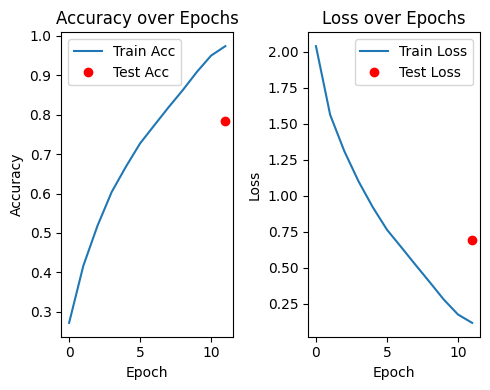

In [7]:
import matplotlib.pyplot as plt

train_acc = train_result.metrics.extra["accuracy_history"]
train_loss = train_result.metrics.extra["loss_history"]
test_acc = test_result.accuracy
test_loss = test_result.loss

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Acc')
plt.plot(len(train_loss)-1, test_acc, 'ro', label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(len(train_loss)-1, test_loss, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### Train shadow models for audit


In [8]:
from leakpro.schemas import LeakProConfig

with open(audit_config_path, "rb") as f:
    audit_configs = yaml.safe_load(f)
    
leakpro_configs = LeakProConfig(**audit_configs)


In [9]:
shadow_dir = audit_configs["audit"]["output_dir"]
print("shadow_dir:", shadow_dir)


shadow_dir: ./B/output


In [10]:
# Instantiate LeakPro with audit configuration
leakpro = LeakPro(CifarInputHandler, audit_config_path)


2025-11-04 17:11:00,897 INFO     Target model blueprint created from WideResNet in ./target_model_class.py.
11/04/2025 17:11:00:INFO:Target model blueprint created from WideResNet in ./target_model_class.py.
2025-11-04 17:11:00,933 INFO     Loaded target model metadata from ./B/target/model_metadata.pkl
11/04/2025 17:11:00:INFO:Loaded target model metadata from ./B/target/model_metadata.pkl
2025-11-04 17:11:00,991 INFO     Loaded target model from ./B/target
11/04/2025 17:11:00:INFO:Loaded target model from ./B/target
2025-11-04 17:11:01,892 INFO     Loaded population dataset from ./data/cifar10.pkl
11/04/2025 17:11:01:INFO:Loaded population dataset from ./data/cifar10.pkl
2025-11-04 17:11:06.490920: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-04 17:11:06.5541

In [11]:
tmp = leakpro.handler.get_labels(selected_index)
tmp.shape, tmp.min(), tmp.max()


((60000,), np.int64(0), np.int64(9))

In [12]:
# Run the audit
mia_results = leakpro.run_audit(create_pdf=True)


2025-11-04 17:11:27,063 INFO     Preparing attack: lira
11/04/2025 17:11:27:INFO:Preparing attack: lira
2025-11-04 17:11:27,405 INFO     Training shadow model 0 on 30000 points
11/04/2025 17:11:27:INFO:Training shadow model 0 on 30000 points
Epoch 1/12: 100%|██████████| 106/106 [00:08<00:00, 12.67it/s, acc=0.3832, loss=1.7345]


Validation loss at epoch 1: 1.4440


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.80it/s, acc=0.5651, loss=1.2116]


Validation loss at epoch 2: 1.2713


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.81it/s, acc=0.6547, loss=0.9660]


Validation loss at epoch 3: 0.9805


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.81it/s, acc=0.7247, loss=0.7718]


Validation loss at epoch 4: 0.9921


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.7771, loss=0.6321]


Validation loss at epoch 5: 0.7784


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.8239, loss=0.5064]


Validation loss at epoch 6: 0.9554


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.66it/s, acc=0.8682, loss=0.3796]


Validation loss at epoch 7: 0.7510


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.9179, loss=0.2441]


Validation loss at epoch 8: 0.9564


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.79it/s, acc=0.9606, loss=0.1325]


Validation loss at epoch 9: 0.7816


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.69it/s, acc=0.9891, loss=0.0514]


Validation loss at epoch 10: 0.6955


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.71it/s, acc=0.9982, loss=0.0199]


Validation loss at epoch 11: 0.6710


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.79it/s, acc=0.9995, loss=0.0133]


Validation loss at epoch 12: 0.6747


2025-11-04 17:13:13,197 INFO     Training shadow model 0 complete
11/04/2025 17:13:13:INFO:Training shadow model 0 complete
2025-11-04 17:13:13,221 INFO     Saved shadow model 0 to ./B/output/attack_objects/shadow_model
11/04/2025 17:13:13:INFO:Saved shadow model 0 to ./B/output/attack_objects/shadow_model
2025-11-04 17:13:13,223 INFO     Storing metadata for shadow model 0
11/04/2025 17:13:13:INFO:Storing metadata for shadow model 0
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.21s/it]
2025-11-04 17:13:23,113 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_0_logits.npy
11/04/2025 17:13:23:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_0_logits.npy
2025-11-04 17:13:23,120 INFO     Metadata for shadow model 0 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:13:23:INFO:Metadata for shadow model 0 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:13:23,480 INFO     Training shadow model 1 on 30000 points
11/04/2025 17

Validation loss at epoch 1: 1.5699


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.80it/s, acc=0.5347, loss=1.2814]


Validation loss at epoch 2: 1.2517


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.6395, loss=1.0124]


Validation loss at epoch 3: 1.1062


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.79it/s, acc=0.7117, loss=0.8160]


Validation loss at epoch 4: 1.0650


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.13it/s, acc=0.7684, loss=0.6694]


Validation loss at epoch 5: 0.9257


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.63it/s, acc=0.8104, loss=0.5423]


Validation loss at epoch 6: 0.9553


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.78it/s, acc=0.8510, loss=0.4272]


Validation loss at epoch 7: 1.2034


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.8992, loss=0.2978]


Validation loss at epoch 8: 0.8267


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.68it/s, acc=0.9493, loss=0.1633]


Validation loss at epoch 9: 0.9048


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.9841, loss=0.0699]


Validation loss at epoch 10: 0.7905


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.9970, loss=0.0281]


Validation loss at epoch 11: 0.7875


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.74it/s, acc=0.9991, loss=0.0183]


Validation loss at epoch 12: 0.7921


2025-11-04 17:15:09,811 INFO     Training shadow model 1 complete
11/04/2025 17:15:09:INFO:Training shadow model 1 complete
2025-11-04 17:15:09,835 INFO     Saved shadow model 1 to ./B/output/attack_objects/shadow_model
11/04/2025 17:15:09:INFO:Saved shadow model 1 to ./B/output/attack_objects/shadow_model
2025-11-04 17:15:09,837 INFO     Storing metadata for shadow model 1
11/04/2025 17:15:09:INFO:Storing metadata for shadow model 1
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.10s/it]
2025-11-04 17:15:19,601 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_1_logits.npy
11/04/2025 17:15:19:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_1_logits.npy
2025-11-04 17:15:19,608 INFO     Metadata for shadow model 1 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:15:19:INFO:Metadata for shadow model 1 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:15:19,971 INFO     Training shadow model 2 on 30000 points
11/04/2025 17

Validation loss at epoch 1: 1.4438


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.80it/s, acc=0.5599, loss=1.2289]


Validation loss at epoch 2: 1.4806


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.6460, loss=0.9953]


Validation loss at epoch 3: 1.1605


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.68it/s, acc=0.7159, loss=0.7981]


Validation loss at epoch 4: 1.0209


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.79it/s, acc=0.7771, loss=0.6399]


Validation loss at epoch 5: 0.8640


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.78it/s, acc=0.8250, loss=0.5014]


Validation loss at epoch 6: 0.8374


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.79it/s, acc=0.8728, loss=0.3641]


Validation loss at epoch 7: 1.0548


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.66it/s, acc=0.9261, loss=0.2249]


Validation loss at epoch 8: 1.2388


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.78it/s, acc=0.9709, loss=0.1045]


Validation loss at epoch 9: 0.8307


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.80it/s, acc=0.9943, loss=0.0340]


Validation loss at epoch 10: 0.8495


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.16it/s, acc=0.9994, loss=0.0130]


Validation loss at epoch 11: 0.8000


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.71it/s, acc=0.9998, loss=0.0092]


Validation loss at epoch 12: 0.8116


2025-11-04 17:17:06,215 INFO     Training shadow model 2 complete
11/04/2025 17:17:06:INFO:Training shadow model 2 complete
2025-11-04 17:17:06,241 INFO     Saved shadow model 2 to ./B/output/attack_objects/shadow_model
11/04/2025 17:17:06:INFO:Saved shadow model 2 to ./B/output/attack_objects/shadow_model
2025-11-04 17:17:06,243 INFO     Storing metadata for shadow model 2
11/04/2025 17:17:06:INFO:Storing metadata for shadow model 2
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.18s/it]
2025-11-04 17:17:16,092 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_2_logits.npy
11/04/2025 17:17:16:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_2_logits.npy
2025-11-04 17:17:16,099 INFO     Metadata for shadow model 2 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:17:16:INFO:Metadata for shadow model 2 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:17:16,439 INFO     Training shadow model 3 on 30000 points
11/04/2025 17

Validation loss at epoch 1: 1.4127


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.81it/s, acc=0.5710, loss=1.1944]


Validation loss at epoch 2: 1.3091


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.82it/s, acc=0.6509, loss=0.9636]


Validation loss at epoch 3: 1.2475


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.94it/s, acc=0.7289, loss=0.7683]


Validation loss at epoch 4: 1.1671


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.92it/s, acc=0.7784, loss=0.6283]


Validation loss at epoch 5: 0.9497


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.8262, loss=0.4925]


Validation loss at epoch 6: 0.9896


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.8698, loss=0.3716]


Validation loss at epoch 7: 0.9060


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.78it/s, acc=0.9239, loss=0.2304]


Validation loss at epoch 8: 0.9462


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.68it/s, acc=0.9696, loss=0.1044]


Validation loss at epoch 9: 0.9858


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.9954, loss=0.0329]


Validation loss at epoch 10: 0.8578


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.9995, loss=0.0139]


Validation loss at epoch 11: 0.8478


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.67it/s, acc=0.9998, loss=0.0102]


Validation loss at epoch 12: 0.8522


2025-11-04 17:19:02,048 INFO     Training shadow model 3 complete
11/04/2025 17:19:02:INFO:Training shadow model 3 complete
2025-11-04 17:19:02,073 INFO     Saved shadow model 3 to ./B/output/attack_objects/shadow_model
11/04/2025 17:19:02:INFO:Saved shadow model 3 to ./B/output/attack_objects/shadow_model
2025-11-04 17:19:02,075 INFO     Storing metadata for shadow model 3
11/04/2025 17:19:02:INFO:Storing metadata for shadow model 3
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.14s/it]
2025-11-04 17:19:11,877 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_3_logits.npy
11/04/2025 17:19:11:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_3_logits.npy
2025-11-04 17:19:11,883 INFO     Metadata for shadow model 3 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:19:11:INFO:Metadata for shadow model 3 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:19:12,230 INFO     Training shadow model 4 on 30000 points
11/04/2025 17

Validation loss at epoch 1: 1.8160


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.73it/s, acc=0.5291, loss=1.2912]


Validation loss at epoch 2: 1.4790


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.78it/s, acc=0.6341, loss=1.0270]


Validation loss at epoch 3: 1.1804


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.79it/s, acc=0.7077, loss=0.8272]


Validation loss at epoch 4: 1.0158


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.7633, loss=0.6710]


Validation loss at epoch 5: 0.9691


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.78it/s, acc=0.8056, loss=0.5593]


Validation loss at epoch 6: 1.0227


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.72it/s, acc=0.8545, loss=0.4285]


Validation loss at epoch 7: 0.9594


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.71it/s, acc=0.8955, loss=0.3057]


Validation loss at epoch 8: 0.9337


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.79it/s, acc=0.9443, loss=0.1775]


Validation loss at epoch 9: 1.1481


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.78it/s, acc=0.9822, loss=0.0741]


Validation loss at epoch 10: 0.7837


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.9970, loss=0.0287]


Validation loss at epoch 11: 0.7849


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.70it/s, acc=0.9989, loss=0.0185]


Validation loss at epoch 12: 0.7840


2025-11-04 17:20:58,447 INFO     Training shadow model 4 complete
11/04/2025 17:20:58:INFO:Training shadow model 4 complete
2025-11-04 17:20:58,472 INFO     Saved shadow model 4 to ./B/output/attack_objects/shadow_model
11/04/2025 17:20:58:INFO:Saved shadow model 4 to ./B/output/attack_objects/shadow_model
2025-11-04 17:20:58,474 INFO     Storing metadata for shadow model 4
11/04/2025 17:20:58:INFO:Storing metadata for shadow model 4
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.16s/it]
2025-11-04 17:21:08,286 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_4_logits.npy
11/04/2025 17:21:08:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_4_logits.npy
2025-11-04 17:21:08,293 INFO     Metadata for shadow model 4 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:21:08:INFO:Metadata for shadow model 4 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:21:08,664 INFO     Training shadow model 5 on 30000 points
11/04/2025 17

Validation loss at epoch 1: 1.6123


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.72it/s, acc=0.5437, loss=1.2494]


Validation loss at epoch 2: 1.1364


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.69it/s, acc=0.6456, loss=0.9819]


Validation loss at epoch 3: 0.9952


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.7151, loss=0.7996]


Validation loss at epoch 4: 0.9184


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.7732, loss=0.6491]


Validation loss at epoch 5: 0.8936


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.19it/s, acc=0.8182, loss=0.5206]


Validation loss at epoch 6: 0.7868


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.8622, loss=0.3995]


Validation loss at epoch 7: 0.9665


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.73it/s, acc=0.9044, loss=0.2774]


Validation loss at epoch 8: 0.7466


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.64it/s, acc=0.9544, loss=0.1470]


Validation loss at epoch 9: 0.8695


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.74it/s, acc=0.9868, loss=0.0591]


Validation loss at epoch 10: 0.7497


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.79it/s, acc=0.9984, loss=0.0228]


Validation loss at epoch 11: 0.6999


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.9996, loss=0.0149]


Validation loss at epoch 12: 0.7007


2025-11-04 17:22:54,926 INFO     Training shadow model 5 complete
11/04/2025 17:22:54:INFO:Training shadow model 5 complete
2025-11-04 17:22:54,952 INFO     Saved shadow model 5 to ./B/output/attack_objects/shadow_model
11/04/2025 17:22:54:INFO:Saved shadow model 5 to ./B/output/attack_objects/shadow_model
2025-11-04 17:22:54,953 INFO     Storing metadata for shadow model 5
11/04/2025 17:22:54:INFO:Storing metadata for shadow model 5
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.16s/it]
2025-11-04 17:23:04,779 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_5_logits.npy
11/04/2025 17:23:04:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_5_logits.npy
2025-11-04 17:23:04,786 INFO     Metadata for shadow model 5 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:23:04:INFO:Metadata for shadow model 5 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:23:05,125 INFO     Training shadow model 6 on 30000 points
11/04/2025 17

Validation loss at epoch 1: 1.6307


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.66it/s, acc=0.4873, loss=1.3902]


Validation loss at epoch 2: 1.3744


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.6021, loss=1.1027]


Validation loss at epoch 3: 1.1222


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.79it/s, acc=0.6740, loss=0.9146]


Validation loss at epoch 4: 1.2008


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.79it/s, acc=0.7375, loss=0.7502]


Validation loss at epoch 5: 0.9783


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.7819, loss=0.6192]


Validation loss at epoch 6: 0.9752


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.8230, loss=0.5065]


Validation loss at epoch 7: 0.8775


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.70it/s, acc=0.8679, loss=0.3870]


Validation loss at epoch 8: 1.0610


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.79it/s, acc=0.9116, loss=0.2635]


Validation loss at epoch 9: 0.9406


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.81it/s, acc=0.9595, loss=0.1374]


Validation loss at epoch 10: 0.7372


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.73it/s, acc=0.9863, loss=0.0646]


Validation loss at epoch 11: 0.7199


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.71it/s, acc=0.9958, loss=0.0385]


Validation loss at epoch 12: 0.7226


2025-11-04 17:24:51,338 INFO     Training shadow model 6 complete
11/04/2025 17:24:51:INFO:Training shadow model 6 complete
2025-11-04 17:24:51,362 INFO     Saved shadow model 6 to ./B/output/attack_objects/shadow_model
11/04/2025 17:24:51:INFO:Saved shadow model 6 to ./B/output/attack_objects/shadow_model
2025-11-04 17:24:51,364 INFO     Storing metadata for shadow model 6
11/04/2025 17:24:51:INFO:Storing metadata for shadow model 6
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.17s/it]
2025-11-04 17:25:01,198 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_6_logits.npy
11/04/2025 17:25:01:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_6_logits.npy
2025-11-04 17:25:01,205 INFO     Metadata for shadow model 6 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:25:01:INFO:Metadata for shadow model 6 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:25:01,543 INFO     Training shadow model 7 on 30000 points
11/04/2025 17

Validation loss at epoch 1: 1.4198


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.66it/s, acc=0.5861, loss=1.1519]


Validation loss at epoch 2: 1.1704


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.72it/s, acc=0.6709, loss=0.9182]


Validation loss at epoch 3: 0.9761


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.82it/s, acc=0.7393, loss=0.7411]


Validation loss at epoch 4: 0.8761


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.79it/s, acc=0.7901, loss=0.5930]


Validation loss at epoch 5: 1.0431


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.80it/s, acc=0.8387, loss=0.4628]


Validation loss at epoch 6: 0.9964


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.79it/s, acc=0.8832, loss=0.3463]


Validation loss at epoch 7: 0.9659


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.74it/s, acc=0.9302, loss=0.2087]


Validation loss at epoch 8: 1.0344


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.73it/s, acc=0.9714, loss=0.1000]


Validation loss at epoch 9: 0.7386


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.80it/s, acc=0.9943, loss=0.0323]


Validation loss at epoch 10: 0.7090


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.78it/s, acc=0.9993, loss=0.0133]


Validation loss at epoch 11: 0.7165


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.78it/s, acc=0.9999, loss=0.0096]


Validation loss at epoch 12: 0.7156


2025-11-04 17:26:47,234 INFO     Training shadow model 7 complete
11/04/2025 17:26:47:INFO:Training shadow model 7 complete
2025-11-04 17:26:47,260 INFO     Saved shadow model 7 to ./B/output/attack_objects/shadow_model
11/04/2025 17:26:47:INFO:Saved shadow model 7 to ./B/output/attack_objects/shadow_model
2025-11-04 17:26:47,262 INFO     Storing metadata for shadow model 7
11/04/2025 17:26:47:INFO:Storing metadata for shadow model 7
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.12s/it]
2025-11-04 17:26:57,048 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_7_logits.npy
11/04/2025 17:26:57:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_7_logits.npy
2025-11-04 17:26:57,056 INFO     Metadata for shadow model 7 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:26:57:INFO:Metadata for shadow model 7 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:26:57,399 INFO     Training shadow model 8 on 30000 points
11/04/2025 17

Validation loss at epoch 1: 1.6645


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.20it/s, acc=0.4813, loss=1.4204]


Validation loss at epoch 2: 1.3997


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.82it/s, acc=0.5842, loss=1.1606]


Validation loss at epoch 3: 1.2632


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.81it/s, acc=0.6697, loss=0.9276]


Validation loss at epoch 4: 1.1649


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.81it/s, acc=0.7354, loss=0.7539]


Validation loss at epoch 5: 0.9042


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.80it/s, acc=0.7874, loss=0.6081]


Validation loss at epoch 6: 0.8896


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.8319, loss=0.4790]


Validation loss at epoch 7: 0.7876


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.72it/s, acc=0.8749, loss=0.3598]


Validation loss at epoch 8: 0.8942


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.69it/s, acc=0.9261, loss=0.2238]


Validation loss at epoch 9: 0.8524


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.9701, loss=0.1079]


Validation loss at epoch 10: 0.7915


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.80it/s, acc=0.9928, loss=0.0459]


Validation loss at epoch 11: 0.7705


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.88it/s, acc=0.9978, loss=0.0282]


Validation loss at epoch 12: 0.7658


2025-11-04 17:28:43,472 INFO     Training shadow model 8 complete
11/04/2025 17:28:43:INFO:Training shadow model 8 complete
2025-11-04 17:28:43,496 INFO     Saved shadow model 8 to ./B/output/attack_objects/shadow_model
11/04/2025 17:28:43:INFO:Saved shadow model 8 to ./B/output/attack_objects/shadow_model
2025-11-04 17:28:43,498 INFO     Storing metadata for shadow model 8
11/04/2025 17:28:43:INFO:Storing metadata for shadow model 8
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.17s/it]
2025-11-04 17:28:53,343 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_8_logits.npy
11/04/2025 17:28:53:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_8_logits.npy
2025-11-04 17:28:53,350 INFO     Metadata for shadow model 8 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:28:53:INFO:Metadata for shadow model 8 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:28:53,696 INFO     Training shadow model 9 on 30000 points
11/04/2025 17

Validation loss at epoch 1: 1.6417


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.65it/s, acc=0.5340, loss=1.2759]


Validation loss at epoch 2: 1.3966


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.6415, loss=1.0046]


Validation loss at epoch 3: 1.3210


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.79it/s, acc=0.7127, loss=0.8018]


Validation loss at epoch 4: 0.8893


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.80it/s, acc=0.7670, loss=0.6632]


Validation loss at epoch 5: 0.9995


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.80it/s, acc=0.8107, loss=0.5357]


Validation loss at epoch 6: 0.8843


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.21it/s, acc=0.8569, loss=0.4190]


Validation loss at epoch 7: 0.8587


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.78it/s, acc=0.8984, loss=0.2975]


Validation loss at epoch 8: 0.8972


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.72it/s, acc=0.9448, loss=0.1710]


Validation loss at epoch 9: 0.9178


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.72it/s, acc=0.9837, loss=0.0695]


Validation loss at epoch 10: 0.7777


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.79it/s, acc=0.9970, loss=0.0291]


Validation loss at epoch 11: 0.7631


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.80it/s, acc=0.9989, loss=0.0183]


Validation loss at epoch 12: 0.7465


2025-11-04 17:30:39,839 INFO     Training shadow model 9 complete
11/04/2025 17:30:39:INFO:Training shadow model 9 complete
2025-11-04 17:30:39,863 INFO     Saved shadow model 9 to ./B/output/attack_objects/shadow_model
11/04/2025 17:30:39:INFO:Saved shadow model 9 to ./B/output/attack_objects/shadow_model
2025-11-04 17:30:39,865 INFO     Storing metadata for shadow model 9
11/04/2025 17:30:39:INFO:Storing metadata for shadow model 9
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.13s/it]
2025-11-04 17:30:49,666 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_9_logits.npy
11/04/2025 17:30:49:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_9_logits.npy
2025-11-04 17:30:49,673 INFO     Metadata for shadow model 9 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:30:49:INFO:Metadata for shadow model 9 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:30:50,017 INFO     Training shadow model 10 on 30000 points
11/04/2025 1

Validation loss at epoch 1: 1.7574


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.68it/s, acc=0.4507, loss=1.4768]


Validation loss at epoch 2: 1.4107


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.78it/s, acc=0.5666, loss=1.1848]


Validation loss at epoch 3: 1.4264


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.6513, loss=0.9734]


Validation loss at epoch 4: 1.3264


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.7196, loss=0.7863]


Validation loss at epoch 5: 0.9055


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.7656, loss=0.6600]


Validation loss at epoch 6: 0.9375


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.82it/s, acc=0.8093, loss=0.5430]


Validation loss at epoch 7: 1.0769


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.88it/s, acc=0.8538, loss=0.4225]


Validation loss at epoch 8: 0.7295


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.71it/s, acc=0.9007, loss=0.2940]


Validation loss at epoch 9: 0.8746


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.73it/s, acc=0.9409, loss=0.1884]


Validation loss at epoch 10: 0.7410


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.74it/s, acc=0.9733, loss=0.1035]


Validation loss at epoch 11: 0.6796


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.9877, loss=0.0669]


Validation loss at epoch 12: 0.6685


2025-11-04 17:32:36,207 INFO     Training shadow model 10 complete
11/04/2025 17:32:36:INFO:Training shadow model 10 complete
2025-11-04 17:32:36,230 INFO     Saved shadow model 10 to ./B/output/attack_objects/shadow_model
11/04/2025 17:32:36:INFO:Saved shadow model 10 to ./B/output/attack_objects/shadow_model
2025-11-04 17:32:36,232 INFO     Storing metadata for shadow model 10
11/04/2025 17:32:36:INFO:Storing metadata for shadow model 10
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.15s/it]
2025-11-04 17:32:46,049 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_10_logits.npy
11/04/2025 17:32:46:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_10_logits.npy
2025-11-04 17:32:46,056 INFO     Metadata for shadow model 10 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:32:46:INFO:Metadata for shadow model 10 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:32:46,400 INFO     Training shadow model 11 on 30000 points
11

Validation loss at epoch 1: 1.5837


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.66it/s, acc=0.5276, loss=1.2926]


Validation loss at epoch 2: 1.2038


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.6261, loss=1.0501]


Validation loss at epoch 3: 1.1010


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.74it/s, acc=0.6982, loss=0.8499]


Validation loss at epoch 4: 1.2287


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.7532, loss=0.6954]


Validation loss at epoch 5: 0.8738


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.8106, loss=0.5423]


Validation loss at epoch 6: 0.9934


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.74it/s, acc=0.8583, loss=0.4144]


Validation loss at epoch 7: 1.0465


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.74it/s, acc=0.9060, loss=0.2742]


Validation loss at epoch 8: 1.1448


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.70it/s, acc=0.9562, loss=0.1425]


Validation loss at epoch 9: 0.9019


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.66it/s, acc=0.9906, loss=0.0480]


Validation loss at epoch 10: 0.8708


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.71it/s, acc=0.9989, loss=0.0179]


Validation loss at epoch 11: 0.8067


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.9997, loss=0.0118]


Validation loss at epoch 12: 0.8114


2025-11-04 17:34:32,518 INFO     Training shadow model 11 complete
11/04/2025 17:34:32:INFO:Training shadow model 11 complete
2025-11-04 17:34:32,543 INFO     Saved shadow model 11 to ./B/output/attack_objects/shadow_model
11/04/2025 17:34:32:INFO:Saved shadow model 11 to ./B/output/attack_objects/shadow_model
2025-11-04 17:34:32,545 INFO     Storing metadata for shadow model 11
11/04/2025 17:34:32:INFO:Storing metadata for shadow model 11
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.20s/it]
2025-11-04 17:34:42,410 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_11_logits.npy
11/04/2025 17:34:42:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_11_logits.npy
2025-11-04 17:34:42,417 INFO     Metadata for shadow model 11 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:34:42:INFO:Metadata for shadow model 11 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:34:42,781 INFO     Training shadow model 12 on 30000 points
11

Validation loss at epoch 1: 1.5145


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.5648, loss=1.1983]


Validation loss at epoch 2: 1.1835


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.06it/s, acc=0.6606, loss=0.9547]


Validation loss at epoch 3: 0.9978


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.68it/s, acc=0.7247, loss=0.7747]


Validation loss at epoch 4: 1.0573


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.7806, loss=0.6220]


Validation loss at epoch 5: 0.8133


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.74it/s, acc=0.8258, loss=0.4947]


Validation loss at epoch 6: 0.7785


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.8747, loss=0.3590]


Validation loss at epoch 7: 0.7768


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.9246, loss=0.2243]


Validation loss at epoch 8: 0.8620


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.68it/s, acc=0.9698, loss=0.1078]


Validation loss at epoch 9: 0.9097


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.67it/s, acc=0.9945, loss=0.0372]


Validation loss at epoch 10: 0.7253


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.9994, loss=0.0148]


Validation loss at epoch 11: 0.7278


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.73it/s, acc=0.9998, loss=0.0111]


Validation loss at epoch 12: 0.7310


2025-11-04 17:36:29,367 INFO     Training shadow model 12 complete
11/04/2025 17:36:29:INFO:Training shadow model 12 complete
2025-11-04 17:36:29,392 INFO     Saved shadow model 12 to ./B/output/attack_objects/shadow_model
11/04/2025 17:36:29:INFO:Saved shadow model 12 to ./B/output/attack_objects/shadow_model
2025-11-04 17:36:29,394 INFO     Storing metadata for shadow model 12
11/04/2025 17:36:29:INFO:Storing metadata for shadow model 12
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.19s/it]
2025-11-04 17:36:39,268 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_12_logits.npy
11/04/2025 17:36:39:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_12_logits.npy
2025-11-04 17:36:39,275 INFO     Metadata for shadow model 12 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:36:39:INFO:Metadata for shadow model 12 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:36:39,634 INFO     Training shadow model 13 on 30000 points
11

Validation loss at epoch 1: 1.6167


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.62it/s, acc=0.5675, loss=1.1956]


Validation loss at epoch 2: 1.2615


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.6709, loss=0.9234]


Validation loss at epoch 3: 1.1161


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.7349, loss=0.7537]


Validation loss at epoch 4: 0.9413


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.7904, loss=0.6013]


Validation loss at epoch 5: 1.4490


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.8336, loss=0.4800]


Validation loss at epoch 6: 0.7491


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.86it/s, acc=0.8788, loss=0.3554]


Validation loss at epoch 7: 0.7572


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.72it/s, acc=0.9217, loss=0.2321]


Validation loss at epoch 8: 0.7837


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.67it/s, acc=0.9661, loss=0.1137]


Validation loss at epoch 9: 0.8056


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.9915, loss=0.0422]


Validation loss at epoch 10: 0.7478


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.9990, loss=0.0168]


Validation loss at epoch 11: 0.7697


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.9997, loss=0.0113]


Validation loss at epoch 12: 0.7684


2025-11-04 17:38:25,992 INFO     Training shadow model 13 complete
11/04/2025 17:38:25:INFO:Training shadow model 13 complete
2025-11-04 17:38:26,017 INFO     Saved shadow model 13 to ./B/output/attack_objects/shadow_model
11/04/2025 17:38:26:INFO:Saved shadow model 13 to ./B/output/attack_objects/shadow_model
2025-11-04 17:38:26,019 INFO     Storing metadata for shadow model 13
11/04/2025 17:38:26:INFO:Storing metadata for shadow model 13
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.11s/it]
2025-11-04 17:38:35,800 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_13_logits.npy
11/04/2025 17:38:35:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_13_logits.npy
2025-11-04 17:38:35,807 INFO     Metadata for shadow model 13 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:38:35:INFO:Metadata for shadow model 13 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:38:36,161 INFO     Training shadow model 14 on 30000 points
11

Validation loss at epoch 1: 1.5288


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.66it/s, acc=0.5403, loss=1.2598]


Validation loss at epoch 2: 1.2613


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.6368, loss=1.0153]


Validation loss at epoch 3: 1.1635


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.7104, loss=0.8160]


Validation loss at epoch 4: 0.8856


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.7670, loss=0.6576]


Validation loss at epoch 5: 1.1791


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.73it/s, acc=0.8201, loss=0.5136]


Validation loss at epoch 6: 0.9493


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.74it/s, acc=0.8724, loss=0.3720]


Validation loss at epoch 7: 1.2901


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.72it/s, acc=0.9221, loss=0.2321]


Validation loss at epoch 8: 0.9409


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.69it/s, acc=0.9711, loss=0.1044]


Validation loss at epoch 9: 0.8501


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.67it/s, acc=0.9959, loss=0.0316]


Validation loss at epoch 10: 0.8843


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.74it/s, acc=0.9994, loss=0.0132]


Validation loss at epoch 11: 0.8881


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.9999, loss=0.0098]


Validation loss at epoch 12: 0.8889


2025-11-04 17:40:22,337 INFO     Training shadow model 14 complete
11/04/2025 17:40:22:INFO:Training shadow model 14 complete
2025-11-04 17:40:22,366 INFO     Saved shadow model 14 to ./B/output/attack_objects/shadow_model
11/04/2025 17:40:22:INFO:Saved shadow model 14 to ./B/output/attack_objects/shadow_model
2025-11-04 17:40:22,368 INFO     Storing metadata for shadow model 14
11/04/2025 17:40:22:INFO:Storing metadata for shadow model 14
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.86s/it]
2025-11-04 17:40:32,895 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_14_logits.npy
11/04/2025 17:40:32:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_14_logits.npy
2025-11-04 17:40:32,903 INFO     Metadata for shadow model 14 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:40:32:INFO:Metadata for shadow model 14 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:40:33,285 INFO     Training shadow model 15 on 30000 points
11

Validation loss at epoch 1: 1.4306


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.64it/s, acc=0.5882, loss=1.1382]


Validation loss at epoch 2: 1.0830


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.79it/s, acc=0.6867, loss=0.8861]


Validation loss at epoch 3: 1.0690


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.7459, loss=0.7220]


Validation loss at epoch 4: 0.9270


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.7991, loss=0.5769]


Validation loss at epoch 5: 0.8971


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.66it/s, acc=0.8435, loss=0.4413]


Validation loss at epoch 6: 1.2932


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.72it/s, acc=0.8902, loss=0.3188]


Validation loss at epoch 7: 1.0399


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.74it/s, acc=0.9458, loss=0.1690]


Validation loss at epoch 8: 1.0828


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.9833, loss=0.0663]


Validation loss at epoch 9: 0.9863


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.73it/s, acc=0.9976, loss=0.0203]


Validation loss at epoch 10: 0.9067


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.63it/s, acc=0.9998, loss=0.0089]


Validation loss at epoch 11: 0.8803


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.73it/s, acc=0.9999, loss=0.0071]


Validation loss at epoch 12: 0.8869


2025-11-04 17:42:19,482 INFO     Training shadow model 15 complete
11/04/2025 17:42:19:INFO:Training shadow model 15 complete
2025-11-04 17:42:19,506 INFO     Saved shadow model 15 to ./B/output/attack_objects/shadow_model
11/04/2025 17:42:19:INFO:Saved shadow model 15 to ./B/output/attack_objects/shadow_model
2025-11-04 17:42:19,508 INFO     Storing metadata for shadow model 15
11/04/2025 17:42:19:INFO:Storing metadata for shadow model 15
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.13s/it]
2025-11-04 17:42:29,313 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_15_logits.npy
11/04/2025 17:42:29:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_15_logits.npy
2025-11-04 17:42:29,320 INFO     Metadata for shadow model 15 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:42:29:INFO:Metadata for shadow model 15 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:42:29,663 INFO     Training shadow model 16 on 30000 points
11

Validation loss at epoch 1: 1.4126


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.5677, loss=1.1934]


Validation loss at epoch 2: 1.7624


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.6606, loss=0.9528]


Validation loss at epoch 3: 1.1153


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.07it/s, acc=0.7266, loss=0.7744]


Validation loss at epoch 4: 0.9785


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.69it/s, acc=0.7847, loss=0.6210]


Validation loss at epoch 5: 1.1018


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.8264, loss=0.4914]


Validation loss at epoch 6: 0.9746


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.8770, loss=0.3550]


Validation loss at epoch 7: 0.8177


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.81it/s, acc=0.9300, loss=0.2137]


Validation loss at epoch 8: 0.8003


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.9727, loss=0.0970]


Validation loss at epoch 9: 0.8692


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.9958, loss=0.0301]


Validation loss at epoch 10: 0.7428


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.9996, loss=0.0123]


Validation loss at epoch 11: 0.7329


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.9998, loss=0.0093]


Validation loss at epoch 12: 0.7389


2025-11-04 17:44:15,961 INFO     Training shadow model 16 complete
11/04/2025 17:44:15:INFO:Training shadow model 16 complete
2025-11-04 17:44:15,985 INFO     Saved shadow model 16 to ./B/output/attack_objects/shadow_model
11/04/2025 17:44:15:INFO:Saved shadow model 16 to ./B/output/attack_objects/shadow_model
2025-11-04 17:44:15,987 INFO     Storing metadata for shadow model 16
11/04/2025 17:44:15:INFO:Storing metadata for shadow model 16
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.13s/it]
2025-11-04 17:44:25,809 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_16_logits.npy
11/04/2025 17:44:25:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_16_logits.npy
2025-11-04 17:44:25,817 INFO     Metadata for shadow model 16 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:44:25:INFO:Metadata for shadow model 16 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:44:26,164 INFO     Training shadow model 17 on 30000 points
11

Validation loss at epoch 1: 1.4538


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.5473, loss=1.2443]


Validation loss at epoch 2: 1.1723


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.72it/s, acc=0.6448, loss=0.9949]


Validation loss at epoch 3: 1.0837


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.63it/s, acc=0.7130, loss=0.8104]


Validation loss at epoch 4: 1.2056


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.70it/s, acc=0.7682, loss=0.6555]


Validation loss at epoch 5: 0.8907


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.74it/s, acc=0.8172, loss=0.5253]


Validation loss at epoch 6: 0.8234


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.74it/s, acc=0.8592, loss=0.4074]


Validation loss at epoch 7: 1.2287


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.72it/s, acc=0.9081, loss=0.2743]


Validation loss at epoch 8: 0.8247


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.73it/s, acc=0.9533, loss=0.1534]


Validation loss at epoch 9: 0.9400


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.19it/s, acc=0.9848, loss=0.0633]


Validation loss at epoch 10: 0.6749


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.9977, loss=0.0251]


Validation loss at epoch 11: 0.7090


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.9991, loss=0.0168]


Validation loss at epoch 12: 0.7088


2025-11-04 17:46:12,642 INFO     Training shadow model 17 complete
11/04/2025 17:46:12:INFO:Training shadow model 17 complete
2025-11-04 17:46:12,667 INFO     Saved shadow model 17 to ./B/output/attack_objects/shadow_model
11/04/2025 17:46:12:INFO:Saved shadow model 17 to ./B/output/attack_objects/shadow_model
2025-11-04 17:46:12,669 INFO     Storing metadata for shadow model 17
11/04/2025 17:46:12:INFO:Storing metadata for shadow model 17
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.11s/it]
2025-11-04 17:46:22,456 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_17_logits.npy
11/04/2025 17:46:22:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_17_logits.npy
2025-11-04 17:46:22,463 INFO     Metadata for shadow model 17 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:46:22:INFO:Metadata for shadow model 17 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:46:22,817 INFO     Training shadow model 18 on 30000 points
11

Validation loss at epoch 1: 1.5366


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.73it/s, acc=0.5115, loss=1.3503]


Validation loss at epoch 2: 1.5601


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.6135, loss=1.0876]


Validation loss at epoch 3: 1.2084


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.74it/s, acc=0.6900, loss=0.8754]


Validation loss at epoch 4: 1.1934


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.70it/s, acc=0.7531, loss=0.7065]


Validation loss at epoch 5: 0.9652


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.63it/s, acc=0.7947, loss=0.5860]


Validation loss at epoch 6: 0.8156


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.72it/s, acc=0.8454, loss=0.4486]


Validation loss at epoch 7: 0.7491


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.8891, loss=0.3225]


Validation loss at epoch 8: 0.8995


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.9360, loss=0.1979]


Validation loss at epoch 9: 0.7639


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.9761, loss=0.0934]


Validation loss at epoch 10: 0.8007


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.9944, loss=0.0389]


Validation loss at epoch 11: 0.7327


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.82it/s, acc=0.9979, loss=0.0254]


Validation loss at epoch 12: 0.7325


2025-11-04 17:48:08,799 INFO     Training shadow model 18 complete
11/04/2025 17:48:08:INFO:Training shadow model 18 complete
2025-11-04 17:48:08,823 INFO     Saved shadow model 18 to ./B/output/attack_objects/shadow_model
11/04/2025 17:48:08:INFO:Saved shadow model 18 to ./B/output/attack_objects/shadow_model
2025-11-04 17:48:08,825 INFO     Storing metadata for shadow model 18
11/04/2025 17:48:08:INFO:Storing metadata for shadow model 18
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.54s/it]
2025-11-04 17:48:19,036 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_18_logits.npy
11/04/2025 17:48:19:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_18_logits.npy
2025-11-04 17:48:19,043 INFO     Metadata for shadow model 18 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:48:19:INFO:Metadata for shadow model 18 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:48:19,431 INFO     Training shadow model 19 on 30000 points
11

Validation loss at epoch 1: 1.6400


Epoch 2/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.5131, loss=1.3254]


Validation loss at epoch 2: 1.5948


Epoch 3/12: 100%|██████████| 106/106 [00:08<00:00, 12.63it/s, acc=0.6194, loss=1.0659]


Validation loss at epoch 3: 1.1358


Epoch 4/12: 100%|██████████| 106/106 [00:08<00:00, 12.74it/s, acc=0.6952, loss=0.8606]


Validation loss at epoch 4: 1.1612


Epoch 5/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.7498, loss=0.7112]


Validation loss at epoch 5: 1.0392


Epoch 6/12: 100%|██████████| 106/106 [00:08<00:00, 12.80it/s, acc=0.8021, loss=0.5685]


Validation loss at epoch 6: 0.8976


Epoch 7/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.8420, loss=0.4494]


Validation loss at epoch 7: 0.7574


Epoch 8/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.8901, loss=0.3245]


Validation loss at epoch 8: 0.9094


Epoch 9/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.9339, loss=0.2037]


Validation loss at epoch 9: 0.9801


Epoch 10/12: 100%|██████████| 106/106 [00:08<00:00, 12.75it/s, acc=0.9729, loss=0.0956]


Validation loss at epoch 10: 0.7596


Epoch 11/12: 100%|██████████| 106/106 [00:08<00:00, 12.76it/s, acc=0.9949, loss=0.0365]


Validation loss at epoch 11: 0.7868


Epoch 12/12: 100%|██████████| 106/106 [00:08<00:00, 12.77it/s, acc=0.9985, loss=0.0223]


Validation loss at epoch 12: 0.7864


2025-11-04 17:50:05,312 INFO     Training shadow model 19 complete
11/04/2025 17:50:05:INFO:Training shadow model 19 complete
2025-11-04 17:50:05,336 INFO     Saved shadow model 19 to ./B/output/attack_objects/shadow_model
11/04/2025 17:50:05:INFO:Saved shadow model 19 to ./B/output/attack_objects/shadow_model
2025-11-04 17:50:05,337 INFO     Storing metadata for shadow model 19
11/04/2025 17:50:05:INFO:Storing metadata for shadow model 19
Getting Model Logits: 100%|██████████| 1/1 [00:09<00:00,  9.18s/it]
2025-11-04 17:50:15,180 INFO     Saved logits to ./B/output/attack_cache/shadow_model/sm_19_logits.npy
11/04/2025 17:50:15:INFO:Saved logits to ./B/output/attack_cache/shadow_model/sm_19_logits.npy
2025-11-04 17:50:15,187 INFO     Metadata for shadow model 19 stored in ./B/output/attack_objects/shadow_model
11/04/2025 17:50:15:INFO:Metadata for shadow model 19 stored in ./B/output/attack_objects/shadow_model
2025-11-04 17:50:15,235 INFO     Loading shadow model 0
11/04/2025 17:50:15:

<Figure size 640x480 with 0 Axes>

In [13]:
from leakpro.attacks.mia_attacks.lira import AttackLiRA
from leakpro.attacks.mia_attacks.rmia import AttackRMIA
from leakpro.attacks.mia_attacks.base import AttackBASE

# Find first of each attack type
lira_attack = next((a for a in leakpro.attack_scheduler.attacks if isinstance(a, AttackLiRA)), None)
assert lira_attack is not None, "No attack of type LiRA was found."
rmia_attack = next((a for a in leakpro.attack_scheduler.attacks if isinstance(a, AttackRMIA)), None)
assert rmia_attack is not None, "No attack of type RMIA was found."
#base_attack = next((a for a in leakpro.attack_scheduler.attacks if isinstance(a, AttackBASE)), None)
#assert base_attack is not None, "No attack of type BASE was found."


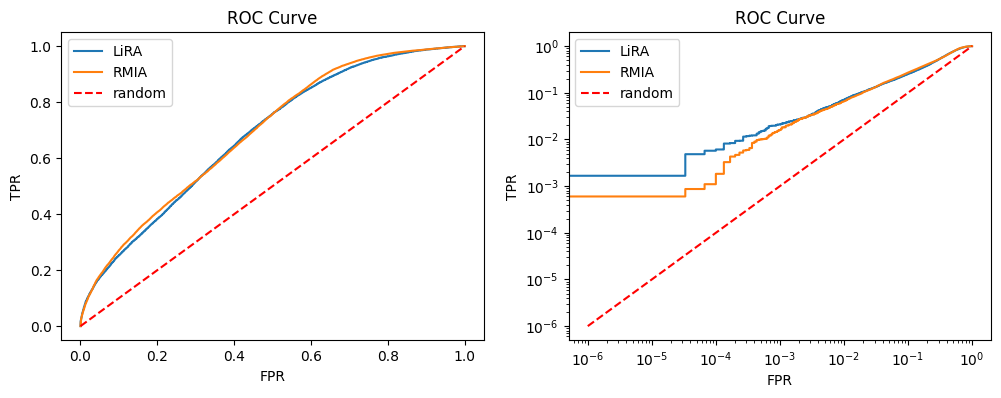

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_results(results, labels=None, smarts=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for ax, flag in zip(axs, [True, False]):
        for i, (fpr, tpr) in enumerate(results):
            label = None if labels is None else labels[i]
            smart = '-' if smarts is None else smarts[i]
            if flag:
                ax.plot(fpr, tpr, smart, label=label)
            else:
                ax.loglog(fpr, tpr, smart, label=label)
        if results:
            diag = np.linspace(1e-6 if not flag else 0.0, 1.0, 200)
            ax.plot(diag, diag, 'r--', label='random')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title('ROC Curve')
        ax.legend()
    plt.show()

mia_roc_curves = []
labels = []
for result in mia_results:
    fpr = getattr(result, 'fpr', None)
    tpr = getattr(result, 'tpr', None)
    if fpr is None or tpr is None:
        continue
    mia_roc_curves.append((fpr, tpr))
    labels.append(result.result_name)

if mia_roc_curves:
    plot_results(mia_roc_curves, labels=labels)
else:
    print('No ROC curves available to plot.')


In [47]:
from leakpro.attacks.utils.shadow_model_handler import ShadowModelHandler

attack = rmia_attack

smh = ShadowModelHandler(attack.handler)

len(attack.handler.population)


2025-11-06 10:52:02,707 INFO     Logits already cached at ./B/output/attack_cache/shadow_model/target_logits.npy
11/06/2025 10:52:02:INFO:Logits already cached at ./B/output/attack_cache/shadow_model/target_logits.npy


60000

In [48]:
target_logits = smh.load_logits(name="target")
tmp = smh.load_logits(name="target")
tmp.shape, tmp.min(), tmp.max()


2025-11-06 10:53:45,082 INFO     Loaded logits from ./B/output/attack_cache/shadow_model/target_logits.npy
11/06/2025 10:53:45:INFO:Loaded logits from ./B/output/attack_cache/shadow_model/target_logits.npy
2025-11-06 10:53:45,092 INFO     Loaded logits from ./B/output/attack_cache/shadow_model/target_logits.npy
11/06/2025 10:53:45:INFO:Loaded logits from ./B/output/attack_cache/shadow_model/target_logits.npy


((60000, 10), np.float32(-9.606997), np.float32(23.05814))

In [50]:
shadow_inmask = smh.get_in_indices_mask(attack.shadow_model_indices, attack.audit_dataset["data"])
tmp = shadow_inmask
tmp.shape, tmp.min(), tmp.max()


2025-11-06 10:54:04,193 INFO     Loading metadata 0
11/06/2025 10:54:04:INFO:Loading metadata 0
2025-11-06 10:54:04,225 INFO     Loading metadata 1
11/06/2025 10:54:04:INFO:Loading metadata 1
2025-11-06 10:54:04,257 INFO     Loading metadata 2
11/06/2025 10:54:04:INFO:Loading metadata 2
2025-11-06 10:54:04,288 INFO     Loading metadata 3
11/06/2025 10:54:04:INFO:Loading metadata 3
2025-11-06 10:54:04,320 INFO     Loading metadata 4
11/06/2025 10:54:04:INFO:Loading metadata 4
2025-11-06 10:54:04,353 INFO     Loading metadata 5
11/06/2025 10:54:04:INFO:Loading metadata 5
2025-11-06 10:54:04,385 INFO     Loading metadata 6
11/06/2025 10:54:04:INFO:Loading metadata 6
2025-11-06 10:54:04,417 INFO     Loading metadata 7
11/06/2025 10:54:04:INFO:Loading metadata 7
2025-11-06 10:54:04,442 INFO     Loading metadata 8
11/06/2025 10:54:04:INFO:Loading metadata 8
2025-11-06 10:54:04,463 INFO     Loading metadata 9
11/06/2025 10:54:04:INFO:Loading metadata 9
2025-11-06 10:54:04,484 INFO     Loading

((60000, 20), np.False_, np.True_)

In [51]:
shadow_logits_list = [smh.load_logits(indx=indx) for indx in attack.shadow_model_indices]
tmp = shadow_inmask[0]
tmp.shape, tmp.min(), tmp.max()


2025-11-06 10:54:34,167 INFO     Loaded logits from ./B/output/attack_cache/shadow_model/sm_0_logits.npy
11/06/2025 10:54:34:INFO:Loaded logits from ./B/output/attack_cache/shadow_model/sm_0_logits.npy
2025-11-06 10:54:34,171 INFO     Loaded logits from ./B/output/attack_cache/shadow_model/sm_1_logits.npy
11/06/2025 10:54:34:INFO:Loaded logits from ./B/output/attack_cache/shadow_model/sm_1_logits.npy
2025-11-06 10:54:34,175 INFO     Loaded logits from ./B/output/attack_cache/shadow_model/sm_2_logits.npy
11/06/2025 10:54:34:INFO:Loaded logits from ./B/output/attack_cache/shadow_model/sm_2_logits.npy
2025-11-06 10:54:34,180 INFO     Loaded logits from ./B/output/attack_cache/shadow_model/sm_3_logits.npy
11/06/2025 10:54:34:INFO:Loaded logits from ./B/output/attack_cache/shadow_model/sm_3_logits.npy
2025-11-06 10:54:34,185 INFO     Loaded logits from ./B/output/attack_cache/shadow_model/sm_4_logits.npy
11/06/2025 10:54:34:INFO:Loaded logits from ./B/output/attack_cache/shadow_model/sm_4_l

((20,), np.False_, np.True_)

In [52]:
print("target_logits",target_logits.shape)
print("len(shadow_logits_list)",len(shadow_logits_list))
print("shadow_logits_list[0]",shadow_logits_list[0].shape)
print("shadow_inmask",shadow_inmask.shape)


target_logits (60000, 10)
len(shadow_logits_list) 20
shadow_logits_list[0] (60000, 10)
shadow_inmask (60000, 20)


In [120]:
%%time

all_indices = np.arange(len(attack.handler.population))
all_labels = attack.handler.get_labels(all_indices)


CPU times: user 5.81 s, sys: 1.7 s, total: 7.51 s
Wall time: 2.32 s


In [121]:
%%time

from leakpro.attacks.utils.utils import softmax_logits
temperature = 1.0
target_gtl_probs = softmax_logits( target_logits, temperature)[all_indices,all_labels]
tmp = target_gtl_probs
tmp.shape, tmp.min(), tmp.max()


CPU times: user 2.27 s, sys: 11.6 ms, total: 2.28 s
Wall time: 79.9 ms


((60000,), np.float32(4.422383e-08), np.float32(1.0))

In [122]:
%%time

shadow_gtl_probs = np.array([softmax_logits(x, temperature)[all_indices,all_labels] for x in shadow_logits_list])
tmp = shadow_gtl_probs
tmp.shape, tmp.min(), tmp.max()


CPU times: user 48 s, sys: 66.1 ms, total: 48 s
Wall time: 1.67 s


((20, 60000), np.float32(3.500163e-11), np.float32(1.0))

In [133]:
from leakpro.attacks.utils.utils import softmax_logits

def rmia_get_gtlprobs(logits, labels, select = None, temperature=1.0):
    select = np.arange(len(labels)) if select is None else select
    assert len(select) == len(labels)
    assert logits.shape[0] > max(select)
    assert logits.shape[1] > max(labels)
    return softmax_logits(logits, temperature)[select,labels]

assert np.all(target_gtl_probs == rmia_get_gtlprobs(target_logits, all_labels))
assert np.all(shadow_gtl_probs[0] == rmia_get_gtlprobs(shadow_logits_list[0], all_labels))


In [134]:
print("target_gtl_probs",target_gtl_probs.shape)
print("shadow_gtl_probs",shadow_gtl_probs.shape)


target_gtl_probs (60000,)
shadow_gtl_probs (20, 60000)


In [124]:
%%time

p_x_given_theta = np.atleast_2d(target_gtl_probs)
p_x_given_shadow_models = shadow_gtl_probs
print("p_x_given_theta",p_x_given_theta.shape)
print("p_x_given_shadow_models",p_x_given_shadow_models.shape)


p_x_given_theta (1, 60000)
p_x_given_shadow_models (20, 60000)
CPU times: user 293 μs, sys: 25 μs, total: 318 μs
Wall time: 320 μs


In [125]:
%%time

z_indices = all_indices[::2]

p_z_given_theta = p_x_given_theta[:,z_indices]
p_z_given_shadow_models = shadow_gtl_probs[:,z_indices]
print("p_z_given_theta",p_z_given_theta.shape)
print("p_z_given_shadow_models",p_z_given_shadow_models.shape)


p_z_given_theta (1, 30000)
p_z_given_shadow_models (20, 30000)
CPU times: user 3.64 ms, sys: 316 μs, total: 3.95 ms
Wall time: 2.91 ms


In [126]:
%%time

# this averages accross shadow models
p_z = np.mean(p_z_given_shadow_models, axis=0, keepdims=True)
p_x = np.mean(p_x_given_shadow_models, axis=0, keepdims=True)
print("p_z",p_z.shape)
print("p_x",p_x.shape)


p_z (1, 30000)
p_x (1, 60000)
CPU times: user 4.68 ms, sys: 56 μs, total: 4.74 ms
Wall time: 4.14 ms


In [71]:
gamma = 1.0
epsilon = 1e-6
n_audit_points = len(all_indices)

ratio_z = p_z_given_theta / (p_z + epsilon)
ratio_x = p_x_given_theta / (p_x + epsilon)

print("ratio_z",ratio_z.shape)
print("ratio_x",ratio_x.shape)


ratio_z (1, 30000)
ratio_x (1, 60000)


In [105]:
%%time

score = np.zeros((1, n_audit_points))
for i in range(n_audit_points):
    likelihoods = ratio_x[0,i] / ratio_z
    score[0, i] = np.mean(likelihoods > gamma)


CPU times: user 4.23 s, sys: 16.7 ms, total: 4.24 s
Wall time: 4.24 s


In [96]:
%%time

likelihoods = ratio_x.T / ratio_z  # shape: (N_x, N_z)
score_vec = np.mean(likelihoods > gamma, axis=1, keepdims=True).T


CPU times: user 2.5 s, sys: 2.64 s, total: 5.14 s
Wall time: 5.14 s


In [97]:
%%time

chunk = 30
# for each x, compute the score
score = [] # np.zeros((1, n_audit_points))
for i in range(int(np.ceil(n_audit_points/chunk))):
    i0 = i*chunk
    i1 = i0 + chunk
    likelihoods = ratio_x[:,i0:i1].T / ratio_z
    temp = np.mean(likelihoods > gamma, axis=1)
    #print(likelihoods.shape, temp.shape)
    score.append(temp)


CPU times: user 3.11 s, sys: 25.9 ms, total: 3.13 s
Wall time: 3.13 s


In [100]:
%%time

from joblib import Parallel, delayed

def compute_score(x_i):
    return np.mean(x_i / ratio_z > gamma)

score_parallel = Parallel(n_jobs=-1)(
    delayed(compute_score)(ratio_x[0, i]) for i in range(n_audit_points)
)


CPU times: user 1min 22s, sys: 3.27 s, total: 1min 25s
Wall time: 1min 22s


In [129]:
%%time

import numpy as np
import torch

# Anta att ratio_x och ratio_z är NumPy-arrayer med shape (1, N_x) och (1, N_z)
batch_size = 1000  # Justera efter din GPU-kapacitet

# Konvertera till PyTorch och flytta till GPU
ratio_x_t = torch.from_numpy(ratio_x).to(torch.float32).to('cuda')  # shape: (1, N_x)
ratio_z_t = torch.from_numpy(ratio_z).to(torch.float32).to('cuda')  # shape: (1, N_z)
gamma_t = torch.tensor(gamma, dtype=torch.float32, device='cuda')

N_x = ratio_x_t.shape[1]
score_list = []

for start_idx in range(0, N_x, batch_size):
    end_idx = min(start_idx + batch_size, N_x)
    batch_x = ratio_x_t[0, start_idx:end_idx].unsqueeze(1)  # shape: (batch_size, 1)
    
    # Broadcasting: (batch_size, 1) / (1, N_z) → (batch_size, N_z)
    likelihoods = batch_x / ratio_z_t
    score_batch = torch.mean((likelihoods > gamma_t).float(), dim=1)  # shape: (batch_size,)
    
    score_list.append(score_batch)

# Slå ihop batcharna till en enda tensor
score_gpu_batched = torch.cat(score_list).unsqueeze(0)  # shape: (1, N_x)

# Flytta GPU-resultatet till CPU och konvertera till NumPy
score_gpu_np = score_gpu_batched.cpu().numpy()


CPU times: user 69.1 ms, sys: 37 μs, total: 69.1 ms
Wall time: 67.8 ms


score.shape: (1, 60000)
score_gpu_batched.shape: torch.Size([1, 60000])


/tmp/ipykernel_2221651/1363496714.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


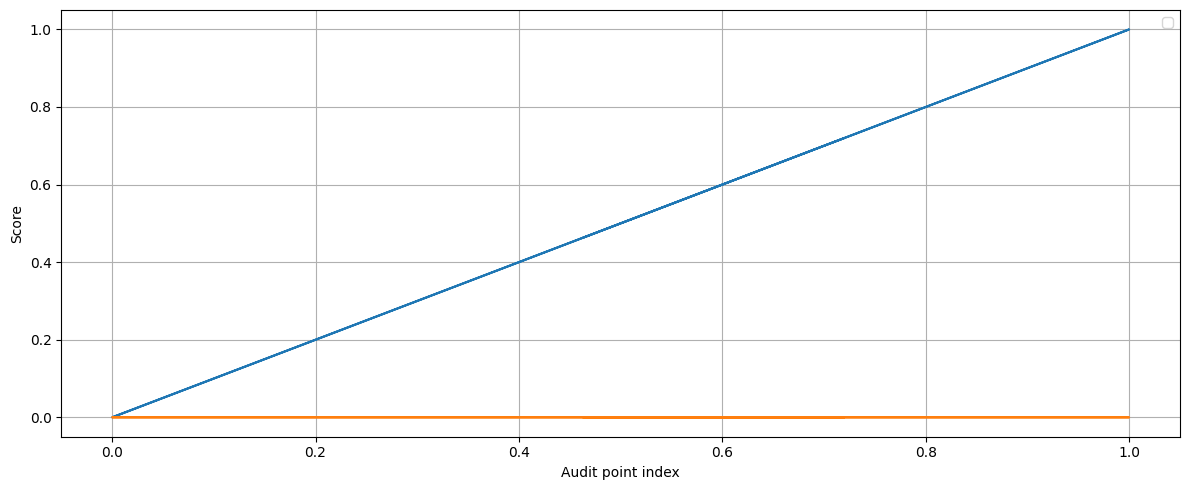

In [130]:
import matplotlib.pyplot as plt


# Kontrollera att shapes matchar
print("score.shape:", score.shape)
print("score_gpu_batched.shape:", score_gpu_batched.shape)

# Plot båda kurvorna
plt.figure(figsize=(12, 5))
plt.plot(score[0, :], score_gpu_np[0, :])
plt.plot(score[0, :], score[0, :]- score_gpu_np[0, :])
plt.xlabel("Audit point index")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [169]:
%%time

#def rmia_accellerated(target_gtlprobs, shadow_gtlprobs, shadow_inmasks=None, x_indices=None, z_indices=None, gamma=1.0, epsilon=1e-12, batch_size=1000):

target_gtlprobs, shadow_gtlprobs = target_gtl_probs, shadow_gtl_probs.T
shadow_inmasks = shadow_inmask
x_indices=None
z_indices=None
gamma=1.0
epsilon=1e-12
batch_size=1000
use_gpu = False

if len(target_gtlprobs.shape)==1:
    target_gtlprobs = target_gtlprobs.reshape(-1,1)

n_population = target_gtlprobs.shape[0]
n_shadow_models = shadow_gtlprobs.shape[1]
print("shadow_gtlprobs", shadow_gtlprobs.shape)
assert shadow_gtlprobs.shape[0]==n_population

if shadow_inmasks is None:
    shadow_inmasks = np.zeros_like(shadow_gtlprobs) 

assert shadow_inmasks.shape==shadow_gtlprobs.shape
print("shadow_inmasks", shadow_inmasks.shape)

if x_indices is None:
    prob_x_given_target = target_gtlprobs
    prob_x_given_shadow = shadow_gtlprobs
else:
    assert min(x_indices) >= 0 and max(x_indices) < n_population
    prob_x_given_target = target_gtlprobs[x_indices,:]
    prob_x_given_shadow = shadow_gtlprobs[x_indices,:]

prob_x = np.mean(prob_x_given_shadow, axis=1, keepdims=True)
ratio_x = prob_x_given_target / (prob_x + epsilon)
print("ratio_x", ratio_x.shape)

if z_indices is None:
    prob_z_given_target = target_gtlprobs
    prob_z_given_shadow = shadow_gtlprobs
else:
    assert min(z_indices) >= 0 and max(z_indices) < n_population
    prob_z_given_target = target_gtlprobs[z_indices,:]
    prob_z_given_shadow = shadow_gtlprobs[z_indices,:]

prob_z = np.mean(prob_z_given_shadow, axis=1, keepdims=True)
ratio_z = prob_z_given_target / (prob_z + epsilon)
print("ratio_z", ratio_z.shape)

n_audit_points = target_gtlprobs.shape[0]

score = [np.mean(ratio_x[i,0] / ratio_z > gamma) for i in range(n_audit_points)]


shadow_gtlprobs (60000, 20)
shadow_inmasks (60000, 20)
ratio_x (60000, 1)
ratio_z (60000, 1)
CPU times: user 3.79 ms, sys: 0 ns, total: 3.79 ms
Wall time: 2.8 ms


In [186]:
%%time

import numpy as np
import torch

def rmia_accellerated(target_gtlprobs, shadow_gtlprobs, shadow_inmasks=None, x_indices=None, z_indices=None, gamma=1.0, epsilon=1e-12, batch_size=1000, use_gpu_if_available=True):

    device = torch.device('cpu')
    if use_gpu_if_available and torch.cuda.is_available():
        device = torch.device('cuda')
    print("Available device:", device)
    
    if len(target_gtlprobs.shape) == 1:
        target_gtlprobs = target_gtlprobs.reshape(-1, 1)
    
    n_population = target_gtlprobs.shape[0]
    n_shadow_models = shadow_gtlprobs.shape[1]
    print("shadow_gtlprobs", shadow_gtlprobs.shape)
    assert shadow_gtlprobs.shape[0] == n_population
    
    if shadow_inmasks is None:
        shadow_inmasks = np.zeros_like(shadow_gtlprobs)
    
    assert shadow_inmasks.shape == shadow_gtlprobs.shape
    print("shadow_inmasks", shadow_inmasks.shape)
    
    if x_indices is None:
        prob_x_given_target = target_gtlprobs
        prob_x_given_shadow = shadow_gtlprobs
    else:
        prob_x_given_target = target_gtlprobs[x_indices, :]
        prob_x_given_shadow = shadow_gtlprobs[x_indices, :]
    
    prob_x = np.mean(prob_x_given_shadow, axis=1, keepdims=True)
    ratio_x = prob_x_given_target / (prob_x + epsilon)
    print("ratio_x", ratio_x.shape)
    
    if z_indices is None:
        prob_z_given_target = target_gtlprobs
        prob_z_given_shadow = shadow_gtlprobs
    else:
        prob_z_given_target = target_gtlprobs[z_indices, :]
        prob_z_given_shadow = shadow_gtlprobs[z_indices, :]
    
    prob_z = np.mean(prob_z_given_shadow, axis=1, keepdims=True)
    ratio_z = prob_z_given_target / (prob_z + epsilon)
    print("ratio_z", ratio_z.shape)
    
    n_audit_points = ratio_x.shape[0]
    score_list = []
    
    ratio_x_t = torch.from_numpy(ratio_x).to(torch.float32).to(device)
    ratio_z_t = torch.from_numpy(ratio_z).to(torch.float32).to(device)
    gamma_t = torch.tensor(gamma, dtype=torch.float32, device=device)
    
    for start_idx in range(0, n_audit_points, batch_size):
        end_idx = min(start_idx + batch_size, n_audit_points)
        batch_x_t = ratio_x_t[start_idx:end_idx, 0].unsqueeze(1)  # shape: (batch_size, 1)
        likelihoods = batch_x_t / ratio_z_t.T  # shape: (batch_size, n_z)
        score_batch = torch.mean((likelihoods > gamma_t).float(), dim=1)  # shape: (batch_size,)
        score_list.append(score_batch)
    
    score_tensor = torch.cat(score_list).unsqueeze(0)  # shape: (1, n_audit_points)
    return score_tensor.cpu().numpy()

score_gpu = rmia_accellerated(target_gtl_probs, shadow_gtl_probs.T, shadow_inmask)
print("score_gpu", score_gpu.shape)


Available device: cuda
shadow_gtlprobs (60000, 20)
shadow_inmasks (60000, 20)
ratio_x (60000, 1)
ratio_z (60000, 1)
score_gpu (1, 60000)
CPU times: user 132 ms, sys: 3.45 ms, total: 135 ms
Wall time: 134 ms


In [ ]:
    def prepare_attack(self:Self) -> None:
        """Prepare Data needed for running the attack on the target model and dataset.

        Signals are computed on the auxiliary model(s) and dataset.
        """
        logger.info("Preparing shadow models for RMIA attack")

        # If we already have one run, we dont need to check for shadow models as logits are stored
        if not self.load_for_optuna:
            self._prepare_shadow_models()

            self.ground_truth_indices = self.handler.get_labels(self.audit_dataset["data"])
            self.logits_theta = ShadowModelHandler().load_logits(name="target")
            self.logits_shadow_models = []
            for indx in self.shadow_model_indices:
                self.logits_shadow_models.append(ShadowModelHandler().load_logits(indx=indx))

        # collect the softmax output of the correct class
        n_attack_points = self.z_data_sample_fraction * len(self.handler.population) # points to compute p(z)

        # pick random indices sampled from the attack data
        z_indices = np.random.choice(self.attack_data_indices, size=int(n_attack_points), replace=False)
        z_labels = self.handler.get_labels(z_indices)

        p_z_given_theta = softmax_logits(self.logits_theta, self.temperature)[z_indices,z_labels]  # noqa: E501
        p_z_given_theta = np.atleast_2d(p_z_given_theta)

        # collect the softmax output of the correct class for each shadow model
        sm_logits_shadow_models = [softmax_logits(x, self.temperature) for x in self.logits_shadow_models]
        p_z_given_shadow_models = np.array([x[z_indices,z_labels] for x in sm_logits_shadow_models])  # noqa: E501

        # evaluate the marginal p(z)
        if self.online is True:
            p_z = np.mean(p_z_given_shadow_models, axis=0, keepdims=True)
        else:
            # create a mask that checks, for each point, if it was in the training set
            p_z = np.mean(p_z_given_shadow_models, axis=0)
            p_z = 0.5*((self.offline_a + 1) * p_z + (1-self.offline_a))

        self.ratio_z = p_z_given_theta / (p_z + self.epsilon)


In [64]:
attack.attack_data_indices # ???

array([  285,  9876, 37866, ..., 38604, 10147, 46597], shape=(60000,))

In [65]:
attack.audit_dataset["data"]

array([    0,     1,     2, ..., 59997, 59998, 59999], shape=(60000,))

In [68]:
attack.prepare_attack()


2025-11-04 14:57:38,713 INFO     Preparing shadow models for RMIA attack
11/04/2025 14:57:38:INFO:Preparing shadow models for RMIA attack


In [69]:
attack.run_attack()


2025-11-04 14:58:25,108 INFO     Running RMIA online attack
11/04/2025 14:58:25:INFO:Running RMIA online attack


In [74]:
attack.ratio_z.shape, np.array(attack.logits_shadow_models).shape

((1, 30000), (2, 60000, 10))

logits 10 classes

prob for true label 

rmia_from_topclass_probs

rmia_from_logits_and_labels



### Train shadow models

In [9]:
from leakpro.schemas import LeakProConfig

with open(audit_config_path, "rb") as f:
    audit_configs = yaml.safe_load(f)
leakpro_configs = LeakProConfig(**audit_configs)


In [10]:
shadow_dir = audit_configs["audit"]["output_dir"]
print("shadow_dir:", shadow_dir)


shadow_dir: ./B/output


In [11]:
import numpy as np

from leakpro.attacks.mia_attacks.lira import AttackLiRA
from leakpro.attacks.utils.shadow_model_handler import ShadowModelHandler
from leakpro.input_handler.mia_handler import MIAHandler

from cifar_handler import CifarInputHandler

# Create the handler, it mostly serves as a dummy handler needed to init the attack but it also creates a dataloader,
# contains the metadata for creating the attack and how shadow models are created for example.

handler = MIAHandler(leakpro_configs, CifarInputHandler)

#configs = handler.configs.audit.attack_list[0] 
for configs in handler.configs.audit.attack_list:
    if configs["attack"] == "lira" and configs["online"]== True:        
        print(f'found online lira attack')
        attack = AttackLiRA(handler=handler, configs=configs)
        break
    else:
        print(f'attack {configs["attack"]} is not lira')
        attack = None

assert configs["attack"]=='lira', "ERROR: attack must be lira"
assert configs["online"]== True, "ERROR: attack must online"


2025-11-04 11:05:51,212 INFO     Target model blueprint created from WideResNet in ./target_model_class.py.
11/04/2025 11:05:51:INFO:Target model blueprint created from WideResNet in ./target_model_class.py.
2025-11-04 11:05:51,277 INFO     Loaded target model metadata from ./B/target/model_metadata.pkl
11/04/2025 11:05:51:INFO:Loaded target model metadata from ./B/target/model_metadata.pkl
2025-11-04 11:05:51,357 INFO     Loaded target model from ./B/target
11/04/2025 11:05:51:INFO:Loaded target model from ./B/target
2025-11-04 11:05:52,437 INFO     Loaded population dataset from ./data/cifar10.pkl
11/04/2025 11:05:52:INFO:Loaded population dataset from ./data/cifar10.pkl


found online lira attack


In [11]:
# Get attack data indices. If true, the whole population is used, otherwise exclude the training data.
attack_data_indices = attack.sample_indices_from_population(include_train_indices = True, include_test_indices = True)

training_data_fraction = attack.training_data_fraction # Use the same fraction as the target model


In [12]:
#Set number of shadow models to train
num_shadow_models = configs["num_shadow_models"]

# Train shadow models
#print("Note that incremental is set to ", INCREMENTAL)
#print("Note that shuffle_shift is set to ", SHUFFLE_SHIFT)
shadow_model_indices = ShadowModelHandler(handler).create_shadow_models(num_models = num_shadow_models,
                                                                shadow_population =  attack_data_indices,
                                                                training_fraction = training_data_fraction,
                                                                online = True, 
                                                                #verbose = False,
                                                                #incremental = INCREMENTAL, 
                                                                #shuffle_shift = SHUFFLE_SHIFT
                                                                       )


2025-11-01 15:10:51,459 INFO     Logits already cached at ./robust/output/attack_cache/shadow_model/target_logits.npy
11/01/2025 15:10:51:INFO:Logits already cached at ./robust/output/attack_cache/shadow_model/target_logits.npy
2025-11-01 15:10:51,777 INFO     Number of existing models exceeds or equals the number of models to create
11/01/2025 15:10:51:INFO:Number of existing models exceeds or equals the number of models to create


In [13]:
# Get the signal function from the attack like this
#signal = attack.signal

# Set the batch size we want to use for the signal function to extract signals faster
attack.handler.dataloader_config.params["batch_size"] = 1024

# Extract our logits
#target_models_logits = np.swapaxes(signal([attack.target_model],
#                                    attack.handler,
#                                    audit_dataset["data"],
#                                ), 0, 1).squeeze()

#print("target_models_logits", target_models_logits.shape)

attack.prepare_attack()

print(attack.shadow_models_logits.shape, attack.target_logits.shape)


2025-11-01 15:10:52,102 INFO     Number of existing models exceeds or equals the number of models to create
11/01/2025 15:10:52:INFO:Number of existing models exceeds or equals the number of models to create
2025-11-01 15:10:52,104 INFO     Loading shadow model 0
11/01/2025 15:10:52:INFO:Loading shadow model 0
2025-11-01 15:10:52,172 INFO     Loaded model from ./robust/output/attack_objects/shadow_model/shadow_model_0.pkl
11/01/2025 15:10:52:INFO:Loaded model from ./robust/output/attack_objects/shadow_model/shadow_model_0.pkl
2025-11-01 15:10:52,174 INFO     Loading shadow model 1
11/01/2025 15:10:52:INFO:Loading shadow model 1
2025-11-01 15:10:52,242 INFO     Loaded model from ./robust/output/attack_objects/shadow_model/shadow_model_1.pkl
11/01/2025 15:10:52:INFO:Loaded model from ./robust/output/attack_objects/shadow_model/shadow_model_1.pkl
2025-11-01 15:10:52,244 INFO     Loading shadow model 2
11/01/2025 15:10:52:INFO:Loading shadow model 2
2025-11-01 15:10:52,331 INFO     Loaded 

(20, 60000) (60000,)


In [14]:
# Get the audit dataset from the attack
audit_dataset = attack.audit_dataset
audit_data_indices = audit_dataset["data"]

# Reconstruct the audit data indices array
target_audit_data_indices = np.concatenate([train_indices, test_indices])
assert all(audit_data_indices == target_audit_data_indices)


In [15]:
# Now create in indices mask for target model compliant with those for shadow
target_in_indices_mask = np.zeros_like(target_audit_data_indices)
target_in_indices_mask[:len(train_indices)] = 1
target_in_indices_mask = target_in_indices_mask.astype(bool)
target_in_indices_mask


array([ True,  True,  True, ..., False, False, False], shape=(60000,))

In [16]:
# Get in indices mask for shadow models 

in_indices_masks = ShadowModelHandler(handler).get_in_indices_mask(shadow_model_indices, audit_dataset["data"])#.astype(int)


2025-11-01 15:10:57,449 INFO     Logits already cached at ./robust/output/attack_cache/shadow_model/target_logits.npy
11/01/2025 15:10:57:INFO:Logits already cached at ./robust/output/attack_cache/shadow_model/target_logits.npy
2025-11-01 15:10:57,451 INFO     Loading metadata 0
11/01/2025 15:10:57:INFO:Loading metadata 0
2025-11-01 15:10:57,470 INFO     Loading metadata 1
11/01/2025 15:10:57:INFO:Loading metadata 1
2025-11-01 15:10:57,488 INFO     Loading metadata 2
11/01/2025 15:10:57:INFO:Loading metadata 2
2025-11-01 15:10:57,507 INFO     Loading metadata 3
11/01/2025 15:10:57:INFO:Loading metadata 3
2025-11-01 15:10:57,525 INFO     Loading metadata 4
11/01/2025 15:10:57:INFO:Loading metadata 4
2025-11-01 15:10:57,543 INFO     Loading metadata 5
11/01/2025 15:10:57:INFO:Loading metadata 5
2025-11-01 15:10:57,561 INFO     Loading metadata 6
11/01/2025 15:10:57:INFO:Loading metadata 6
2025-11-01 15:10:57,579 INFO     Loading metadata 7
11/01/2025 15:10:57:INFO:Loading metadata 7
2025

In [17]:
filepath = target_dir + "/signals"
os.makedirs(filepath, exist_ok=True)

print("store target results in ", filepath)

np.save(filepath + "/rescaled_logits.npy", attack.target_logits[:,None]) # make it 2D array
np.save(filepath + "/in_indices_masks.npy", target_in_indices_mask[:,None]) #  make it 2D array
np.save(filepath + "/audit_data_indices.npy", target_audit_data_indices)

print("attack.target_logits", attack.target_logits.shape)
print("target_in_indices_mask", target_in_indices_mask.shape)


store target results in  ./robust/target/signals
attack.target_logits (60000,)
target_in_indices_mask (60000,)


In [18]:
filepath = shadow_dir + "/signals"
os.makedirs(filepath, exist_ok=True)

print("store shadow results in ", filepath)

np.save(filepath + "/rescaled_logits.npy", attack.shadow_models_logits.T)
np.save(filepath + "/in_indices_masks.npy", in_indices_masks)
np.save(filepath + "/audit_data_indices.npy", audit_data_indices)

print("shadow_models_logits", attack.shadow_models_logits.shape)
print("in_indices_masks", in_indices_masks.shape)


store shadow results in  ./robust/output/signals
shadow_models_logits (20, 60000)
in_indices_masks (60000, 20)
